# Data Cleaning Challenge + Text Ananlysis

This project is based on Airbnb Dataset from Kaggle (https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata) and consist of 2 parts. In the first part I will clean data for a descriptive analysis in part 2. Let's get crackin!

In [1]:
# loading packages
from folium.plugins import MarkerCluster
from IPython.display import HTML
from textblob import TextBlob
import folium
from geopy.geocoders import Nominatim
from IPython.display import IFrame
import string
import re
from nltk.corpus import stopwords
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import datetime
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial import cKDTree 
import numpy as np
import sys
import warnings
import seaborn as sns
from haversine import haversine
import matplotlib.pyplot as plt
from scipy.spatial import distance
if not sys.warnoptions:
    warnings.simplefilter("ignore")


pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50000
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import re
from collections import Counter
#######################################################
def summarize_df(df,show_uniques=None):
    """
    Summarizes pandas dataframe and checks:
    \n-unique values\n-missing values\n-dtypes
    \n-boolean for column names that contain 'id' permutations
    \n-column names that contains 'date' permutations and their corresponding date format
    \n-date formats
    \n-[optional] sampled (n=3) unique values
    \nIts output can serve as the partial input of the date_converter function!
    """
    no_unique_values=df.apply(lambda column: len(column.unique()),axis=0).values
    missing_values=df.apply(lambda column: 100-(len(column.dropna())/len(df))*100,axis=0).values
    dtypes=[df[colname].drop_duplicates().apply(lambda cell: type(cell)).unique().tolist() for colname in df.columns]
    id_cols=pd.Series(df.columns).str.contains('id|Id|ID|Id.|id.|ID.').values
    df_summary=pd.DataFrame(
        index=df.columns
    )
    df_summary['no_unique_values'],df_summary['missing_values(%)'],df_summary['dtypes'],df_summary['id_col']=no_unique_values,missing_values,dtypes,id_cols

    date_fil=pd.Series(df_summary.index).str.contains('date|Date|time|Time|DATE').values
    date_format=pd.Series(df_summary.loc[date_fil,:].index).apply(
        lambda colname: df[colname].dropna().values[0] if len(df[colname].dropna())!=0 else np.nan
    )
    date_format.index=df_summary.loc[date_fil,:].index
    df_summary['date_format']=pd.Series(df_summary.index).apply(
        lambda colname: date_format[colname] if colname in date_format.index else np.nan
    ).values
    if show_uniques==True:
        unique_values_sample=df.apply(
            lambda column: ', '.join(list(map(str,column.dropna().unique().tolist()[:3]))) if len(column.dropna().unique())>0 else np.nan,axis=0
        ).values
        df_summary['unique_values_sample']=unique_values_sample
    return df_summary

## Part 1. Data Cleaning

Let's take a first look at the data. It contains information about various properties listed for short-term rental, on a platform called Airbnb. It contains such details as ID, name, host information, location (neighbourhood, neighbourhood group, latitude, and longitude), booking details (instant bookable, cancellation policy, room type), pricing information, minimum nights stay, number of reviews, and other related details.

The dataset includes both numerical and categorical data, providing a comprehensive view of each property's characteristics. Additionally, there are columns such as "house_rules" and "license" that contain specific rules for guests and information about the property's licensing.

In [2]:
df = pd.read_csv("Airbnb_Open_Data.csv", low_memory = False, error_bad_lines=False)
# only us observations, useless column
del df['country']
del df['country code']
df.head(5)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,False,strict,Private room,2020.00000,$966,$193,10.00000,9.00000,10/19/2021,0.21000,4.00000,6.00000,286.00000,Clean up and treat the home the way you'd like your home to be treated. No smoking.,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,False,moderate,Entire home/apt,2007.00000,$142,$28,30.00000,45.00000,5/21/2022,0.38000,4.00000,2.00000,228.00000,Pet friendly but please confirm with me if the pet you are planning on bringing with you is OK. I have a cute and quiet mixed chihuahua. I could accept more guests (for an extra fee) but this also needs to be confirmed beforehand. Also friends traveling together could sleep in separate beds for an extra fee (the second bed is either a sofa bed or inflatable bed). Smoking is only allowed on the porch.,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,True,flexible,Private room,2005.00000,$620,$124,3.00000,0.00000,NaN,NaN,5.00000,1.00000,352.00000,"I encourage you to use my kitchen, cooking and laundry facilities. There is no additional charge to use the washer/dryer in the basement. No smoking, inside or outside. Come home as late as you want. If you come home stumbling drunk, it's OK the first time. If you do it again, and you wake up me or the neighbors downstairs, we will be annoyed. (Just so you know . . . )",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,True,moderate,Entire home/apt,2005.00000,$368,$74,30.00000,270.00000,7/5/2019,4.64000,4.00000,1.00000,322.00000,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,False,moderate,Entire home/apt,2009.00000,$204,$41,10.00000,9.00000,11/19/2018,0.10000,3.00000,1.00000,289.00000,"Please no smoking in the house, porch or on the property (you can go to the nearby corner). Reasonable quiet after 10:30 pm. Please remove shoes in the house.",NaN


### Handling full duplicates

Let's calculate how many rows in dataset are full duplicates of each other. It is about 1 %, so we can just drop  these rows.

In [3]:
duplicates_id = df[df.duplicated(keep=False)]
print('Duplicate rows, %:', (duplicates_id.shape[0]/df.shape[0])*100)

Duplicate rows, %: 1.0545911753525863


In [4]:
df = df.sort_values(by='id', ascending=False)
df = df.drop_duplicates(keep='first')

### Taking a deeper look at the data, handling NAs and data cleaning

Let's do a descriptive statistcs of the data and also build a graph that will depict where the NAs are in dataset. 

The dataset comprises 102,058 rows and 24 columns, each representing specific details about properties listed for short-term rental. Notable statistics include:

- **No. of Unique Values:**
  - The 'id' column has 102,058 unique values, ensuring each entry is distinct.
  - 'host_id' has 61,282 unique values, indicating diverse property ownership.
  
- **Missing Values (%):**
  - Some columns have minimal or no missing values, while 'license' exhibits a high percentage (50.8%), suggesting substantial data gaps.

- **Data Types:**
  - 'id' is of integer type, while 'name' and 'host_id' are a combination of strings and floats.
  - Various columns feature boolean, string, and float data types.

- **Identity Check:**
  - 'id_col' identifies 'id' as a unique identifier column.
  
- **Sample Unique Values:**
  - Examples of unique values include specific 'id' numbers, property names, 'host_id' numbers, and verification statuses.

Regarding the distribution of NAs in the data, they are located in different data rows, so we can't just drop them entirely, they need to be explored more deeply. 

In [5]:
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

analys_s=summarize_df(df=df,show_uniques=True)
pd.set_option('display.max_columns', None)
analys_s.T

Number of rows: 102058
Number of columns: 24


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
no_unique_values,102058,61282,102057,3,13191,8,225,21992,17775,3,4,4,21,1152,232,154,477,2478,1017,6,79,439,1977,2
missing_values(%),0.00000,0.24496,0.00000,0.28317,0.39585,0.02842,0.01568,0.00784,0.00784,0.10288,0.07447,0.00000,0.20968,0.24202,0.26749,0.39193,0.17931,15.51275,15.49903,0.31257,0.31257,0.43897,50.79661,99.99804
dtypes,[<class 'int'>],"[<class 'str'>, <class 'float'>]",[<class 'int'>],"[<class 'str'>, <class 'float'>]","[<class 'str'>, <class 'float'>]","[<class 'str'>, <class 'float'>]","[<class 'str'>, <class 'float'>]",[<class 'float'>],[<class 'float'>],"[<class 'bool'>, <class 'float'>]","[<class 'str'>, <class 'float'>]",[<class 'str'>],[<class 'float'>],"[<class 'str'>, <class 'float'>]","[<class 'float'>, <class 'str'>]",[<class 'float'>],[<class 'float'>],"[<class 'str'>, <class 'float'>]",[<class 'float'>],[<class 'float'>],[<class 'float'>],[<class 'float'>],"[<class 'str'>, <class 'float'>]","[<class 'float'>, <class 'str'>]"
id_col,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date_format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique_values_sample,"57367417, 57366865, 57366313","Rosalee Stewart, Room & private bathroom in historic Harlem, Pretty Brooklyn One-Bedroom for 2 to 4 people","93578954226, 15593031571, 23801060917","verified, unconfirmed","Stanley, Shireen, Michael","Manhattan, Brooklyn, Queens","Harlem, Bedford-Stuyvesant, Bushwick","40.81315, 40.81248, 40.6781","-73.94747, -73.94317, -73.90822","False, True","flexible, strict, moderate","Entire home/apt, Private room, Shared room","2011.0, 2016.0, 2020.0","$1,128 , $848 , $387","$162 , $209 , $141","4.0, 2.0, 1.0","22.0, 0.0, 50.0","6/15/2019, 6/26/2019, 8/31/2017","0.85, 3.12, 0.72","4.0, 1.0, 3.0","1.0, 2.0, 3.0","238.0, 0.0, 235.0","Please remember that this is a residential building. All building rules, Hotel occupancy restrictions, and year-round tenants must be respected., Each of us is working and/or going to school at the moment, so weekday guests are expected to respect a quiet period from 12am to 8am. On weekends, we almost always go out and encourage you to do the same! You're welcome to make noise in your room at a reasonable level, but we prefer that you wrap it up no later than 3am at the absolute latest on weekends., * Check out: 10am * We made an effort to keep things organized. Please help us to maintain the house as beautiful and clean as possible. * Please ask before bringing visitors, and sorry I can only allow the number of guest on the reservation to stay overnight. * I also ask that shoes not be worn in the house to keep the wood floors clean, and that you only eat in the dining room area.",41662/AL


<AxesSubplot:>

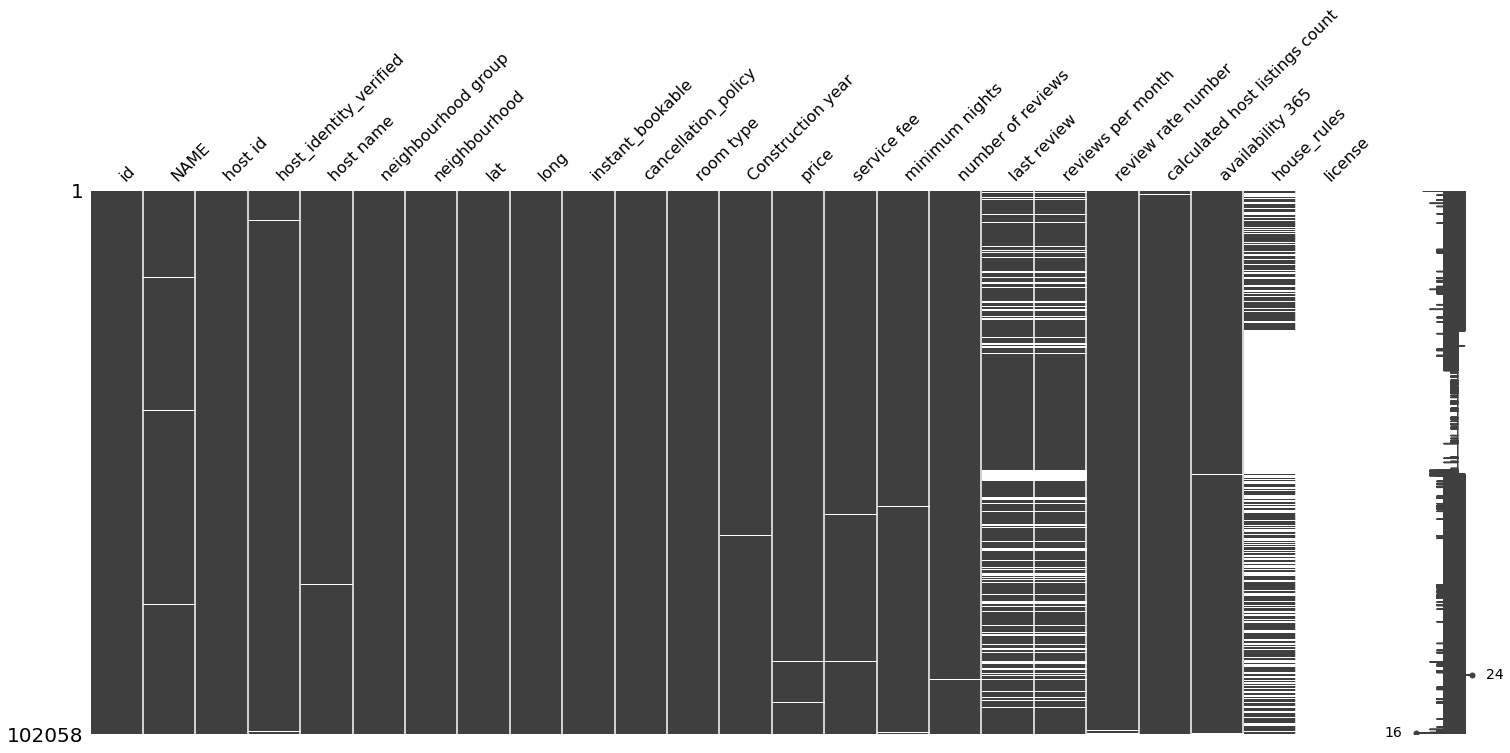

In [6]:
msno.matrix(df)

However, we can drop NAs in columns where NAs are less than 1% of the whole data. Let's see how much % of the whole dataset will stay. Loosing meven more than 2% fo the whole datatset can lead to further analysis bias. Maybe if to observe each column sepaately it can minimise this %?

In [7]:
df1 = df.dropna(subset=['Construction year', 'host_identity_verified', 'NAME', 'long', 'instant_bookable', 'lat', 'neighbourhood', 'host id', 'minimum nights', 'host name', 'calculated host listings count', 'availability 365', 'number of reviews'], how='any')
print('dataset volume(%) without last review and house_rules columns:', (df1.shape[0]/df.shape[0])*100)

dataset volume(%) without last review and house_rules columns: 97.63761782515824


### Handling each column separately

Each column has its own specifications for further analysis, so I will handle them sort of separately.

Once we address these anomalies, we can delve into numerical columns, changing data type where necessary. The 'price' column, for instance, may need normalization or outlier removal to prevent skewed analyses. 

Firstly, let's check categorical values for typoes.To ensure data accuracy, scrutinize categorical values for typos or inconsistencies.
- 'Brooklyn' appears as 'brookln' and 'manhatan' (likely a typo) with only one occurrence.
- License: Most listings lack a license ('False'), but two entries have '41662/AL' as a potential typo or unique case.

In [8]:
print(df['host_identity_verified'].value_counts().sort_index())
print(df['neighbourhood group'].value_counts().sort_index())
print(df['neighbourhood'].value_counts().sort_index())
print(df['instant_bookable'].value_counts().sort_index())
print(df['cancellation_policy'].value_counts().sort_index())
print(df['license'].value_counts().sort_index())

unconfirmed    50944
verified       50825
Name: host_identity_verified, dtype: int64
Bronx             2694
Brooklyn         41630
Manhattan        43557
Queens           13197
Staten Island      949
brookln              1
manhatan             1
Name: neighbourhood group, dtype: int64
Allerton                        96
Arden Heights                    9
Arrochar                        51
Arverne                        219
Astoria                       1868
Bath Beach                      47
Battery Park City              117
Bay Ridge                      301
Bay Terrace                      8
Bay Terrace, Staten Island       4
Baychester                      27
Bayside                        122
Bayswater                       40
Bedford-Stuyvesant            7898
Belle Harbor                    30
Bellerose                       26
Belmont                         45
Bensonhurst                    156
Bergen Beach                    30
Boerum Hill                    357
Borough Park  

In [9]:
df['neighbourhood group'] = df['neighbourhood group'].replace('brookln', 'Brooklyn').replace('manhatan', 'Manhattan')

#### 'neighbourhood group'
There are some NA values in 'neighbourhood group', which stands one level below 'neighbourhood' in the hiereachy. Let's match NAs by neighbourhood. 

In [10]:
print('NAs in neighbourhood group:', df['neighbourhood group'].isna().sum())

NAs in neighbourhood group: 29


In [11]:
neigh = df.sort_values(by='neighbourhood', ascending=False)
neigh = neigh.drop_duplicates(subset='neighbourhood', keep='first')
neigh = neigh[['neighbourhood', 'neighbourhood group']]
df = df.merge(neigh, on='neighbourhood', how='left')
del df['neighbourhood group_x']
df.rename(columns={'neighbourhood group_y': 'neighbourhood group'}, inplace=True)
print('NAs in neighbourhood group after matching:', df['neighbourhood group'].isna().sum())

NAs in neighbourhood group after matching: 0


#### 'price'
The next column to observe is 'price'. It's a good idea to fill missing values by average in each neighbourhood and room type, so it would be more accurate. That way, we ensure a nuanced approach, reflecting the local context. Plus, it minimizes distortions in pricing, giving us a clearer picture for analysis.

In [12]:
#how many nas in price by neighbourhood (%)?
na_percentage = df.groupby('neighbourhood')['price'].apply(lambda x: (x.isna().sum() / len(x)) * 100)
na_percentage.sort_values(ascending=False)

neighbourhood
Unionport                    4.54545
Jamaica Estates              4.00000
Tremont                      3.33333
Bronxdale                    2.17391
Clason Point                 2.00000
Arrochar                     1.96078
Briarwood                    1.65289
Stapleton                    1.53846
Laurelton                    1.51515
Allerton                     1.04167
Tompkinsville                0.90909
Woodside                     0.85470
Gravesend                    0.71429
NoHo                         0.71429
Jackson Heights              0.66964
Fordham                      0.65789
Kingsbridge                  0.60976
Cypress Hills                0.59701
SoHo                         0.58737
Greenwich Village            0.53908
Woodhaven                    0.52632
East Village                 0.51769
Flushing                     0.50761
Flatlands                    0.46083
Midwood                      0.42735
Rego Park                    0.42553
Murray Hill             

In [13]:
# Convert 'price' column to numeric and fill by mean of neighbourhood and room type
df['price'] = pd.to_numeric(df['price'].str.replace('[\$,]', '', regex=True), errors='coerce')
mean_prices = df.groupby(['neighbourhood', 'room type'])['price'].mean()
# Fill missing 'price' values based on the mean prices
df['price'] = df.apply(lambda row: mean_prices.get((row['neighbourhood'], row['room type']), row['price']), axis=1)

#### 'service fee'
If there is no 0 in 'service fee', this can mean that Nas are simply objects where service fee is 0. The minimum value there is in the column is 10, so let's ssume so and replace missing values with 0.

In [14]:
#converting to numeric
df['service fee'] = pd.to_numeric(df['service fee'].str.replace('[\$,]', '', regex=True), errors='coerce')

In [15]:
df['service fee'].min()

10.0

In [16]:
#filling nas in service fee just by 0, because the min is 10
df['service fee'] = df['service fee'].fillna(0)

#### 'minimum nights'
The discovery that there are values below zero prompts a more detailed exploration. The subsequent boxplot visualization for 'minimum nights' reveals the distribution of values, helping identify outliers and the overall spread.

Calculating the percentage of values below zero, shedds the light on the extent of this anomaly. Following statistical insights such as quartiles (Q1, Q2, Q3) and the 95th percentile, the code aims for a comprehensive understanding of the data distribution.

To address outliers, values below zero or above 30 are replaced with 0, ensuring a more realistic representation. Additionally, missing values in the 'minimum nights' column are filled with a default value of 3, enhancing the dataset's completeness.

In [17]:
df['minimum nights'].min()

-1223.0

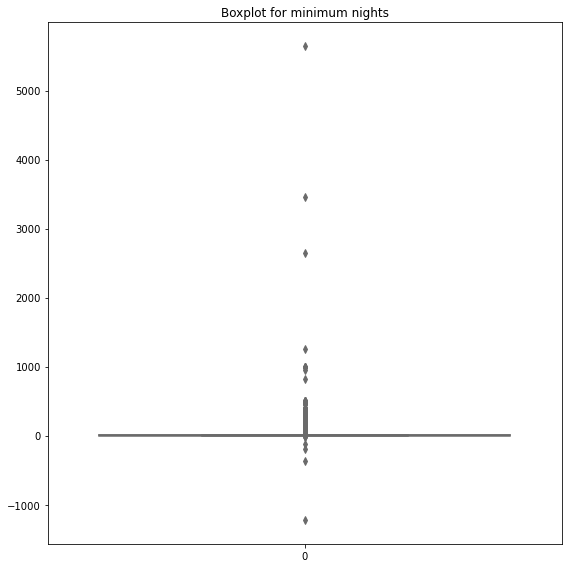

In [18]:
#sounds not good. lets make a boxplot to discover values more
columns_to_plot = ['minimum nights']

aspect_ratio = 8  
colors = sns.color_palette('Set3', n_colors=len(columns_to_plot))

plt.figure(figsize=(8, aspect_ratio * len(columns_to_plot)))  

for i, (col, color) in enumerate(zip(columns_to_plot, colors), 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.boxplot(data=df[col], color=color) 
    plt.title(f'Boxplot for {col}')

plt.tight_layout() 
plt.show()

In [19]:
# Calculate the percentage of values below 0
count_below_zero = (df['minimum nights'] < 0).sum()
total_values = len(df)
percentage_below_zero = (count_below_zero / total_values) * 100

print(f"Percentage of values below 0 in minimum nights: {percentage_below_zero:.2f}%")

Percentage of values below 0 in minimum nights: 0.01%


In [20]:
q1 = df['minimum nights'].quantile(0.25)
q2 = df['minimum nights'].quantile(0.5)  # Median
q3 = df['minimum nights'].quantile(0.75)
q4 = df['minimum nights'].quantile(0.95)
print(f"Q1 (25th percentile): {q1}")
print(f"Q2 (50th percentile - Median): {q2}")
print(f"Q3 (75th percentile): {q3}")
print(f"(95th percentile): {q4}")

Q1 (25th percentile): 2.0
Q2 (50th percentile - Median): 3.0
Q3 (75th percentile): 5.0
(95th percentile): 30.0


In [21]:
# Replace values below 0 or above 30 with 0 in col1
df['minimum nights'] = df['minimum nights'].apply(lambda x: 0 if x < 0 or x > 30 else x)
df['minimum nights'] = df['minimum nights'].fillna(3)

#### 'house_rules' is a descriptive text column - no need to drop NAs here, just state thet there is no text in it. 

In [22]:
df['house_rules'] = df['house_rules'].fillna('-')

#### 'reviews per month' and 'review rate number'

These columns are interconnected, so let's work on them in parallel. To address missing values, both columns have NaN values replaced with their respective means, a sensible strategy for maintaining statistical accuracy while filling gaps in the dataset.

col min: 0.01
col max: 90.0
col mean: 1.3754082792208238


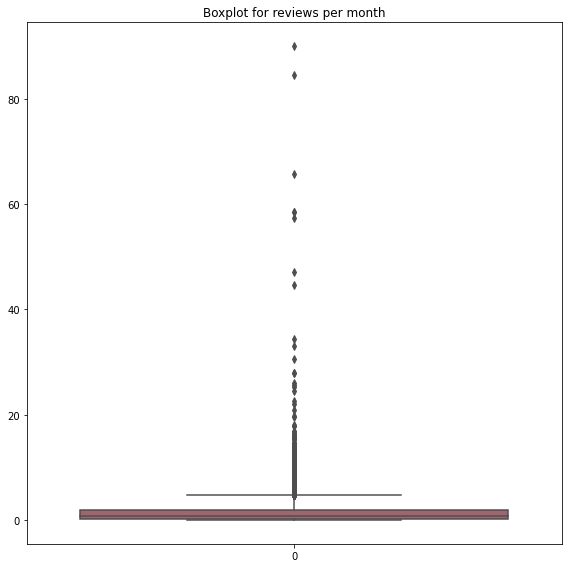

In [23]:
#checking for outliers
print ('col min:', df['reviews per month'].min())
print ('col max:', df['reviews per month'].max())
print ('col mean:', df['reviews per month'].mean())

columns_to_plot = ['reviews per month']

aspect_ratio = 8  


plt.figure(figsize=(8, aspect_ratio * len(columns_to_plot)))  

for i, (col, color) in enumerate(zip(columns_to_plot, colors), 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.boxplot(data=df[col], color='#A95C68') 
    plt.title(f'Boxplot for {col}')

plt.tight_layout() 
plt.show()

col min: 1.0
col max: 5.0
col mean: 3.2787328359822685


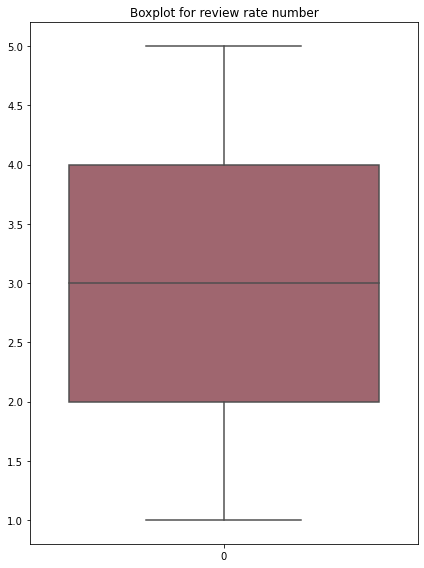

In [24]:
#checking for outliers
print ('col min:', df['review rate number'].min())
print ('col max:', df['review rate number'].max())
print ('col mean:', df['review rate number'].mean())

columns_to_plot = ['review rate number']

aspect_ratio = 8  

plt.figure(figsize=(6, aspect_ratio * len(columns_to_plot)))  

for i, (col, color) in enumerate(zip(columns_to_plot, colors), 1):
    plt.subplot(len(columns_to_plot), 1, i)
    sns.boxplot(data=df[col], color='#A95C68') 
    plt.title(f'Boxplot for {col}')

plt.tight_layout() 
plt.show()

In [25]:
#replacing nas with mean
df["reviews per month"].fillna(df["reviews per month"].mean(),inplace=True)
df["review rate number"].fillna(df["review rate number"].mean(),inplace=True)

#### 'last review' 
This is a date column - to simplify further analysis, it is a good idea to replace dates with categories (old, new, not known) and check dates for logic: the year cannot be more then 2022, this is the scope of the initial data, so if it exsists in dataset, we will categorise it as 'no date'

In [26]:
# Convert the 'col1' column to datetime objects
df['last review'] = pd.to_datetime(df['last review'], format='%m/%d/%Y')

# Find the minimum and maximum dates
min_date = df['last review'].min()
max_date = df['last review'].max()

# Display the results
print(f"Minimum date: {min_date.date()}")
print(f"Maximum date: {max_date.date()}")

Minimum date: 2012-07-11
Maximum date: 2058-06-16


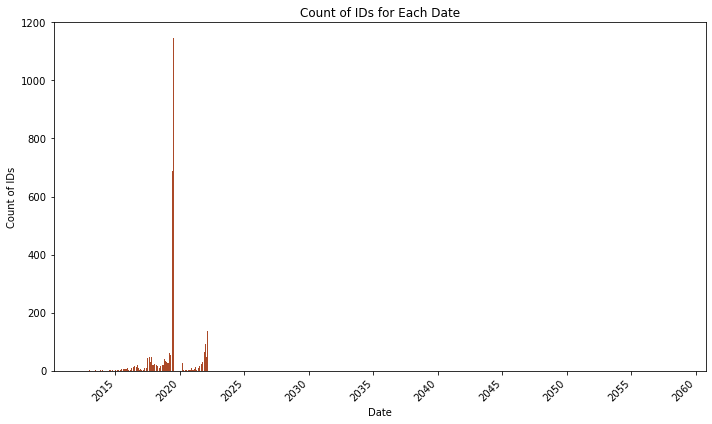

In [27]:
# Grouping by Date and getting the count of IDs
date_counts = df.groupby('last review')['id'].count().reset_index()

plt.figure(figsize=(10, 6))

# Plotting
plt.bar(date_counts['last review'], date_counts['id'], color='#AB4928')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Count of IDs')
plt.title('Count of IDs for Each Date')

# Formatting x-axis date labels
plt.xticks(rotation=45, ha='right')
# Setting y-axis limit
plt.ylim(0, 1200)
plt.tight_layout()
plt.show()

In [28]:
date_ranges = {
    '2012-2015': pd.date_range('2012-01-01', '2015-12-31'),
    '2016-2019': pd.date_range('2016-01-01', '2019-12-31'),
    '2020-2022': pd.date_range('2020-01-01', '2022-12-31')
}

# Categorize dates
def categorize_date(date):
    for range_label, date_range in date_ranges.items():
        if date in date_range:
            return range_label
    return 'no date'

df['last review category'] = df['last review'].apply(categorize_date)

In [29]:
print(df['last review category'].value_counts().sort_index())

2012-2015     2202
2016-2019    65031
2020-2022    18988
no date      15837
Name: last review category, dtype: int64


#### Last step of data cleaning, recheck of data types
All good, let's begin part 2!

In [30]:
df.dtypes

id                                         int64
NAME                                      object
host id                                    int64
host_identity_verified                    object
host name                                 object
neighbourhood                             object
lat                                      float64
long                                     float64
instant_bookable                          object
cancellation_policy                       object
room type                                 object
Construction year                        float64
price                                    float64
service fee                              float64
minimum nights                           float64
number of reviews                        float64
last review                       datetime64[ns]
reviews per month                        float64
review rate number                       float64
calculated host listings count           float64
availability 365    

## Part 2. Explanatory analysis + Text Ananlysis

In this phase, we embark on a nuanced exploration of the Airbnb dataset, intertwining explanatory and text analyses to unravel hidden narratives. Through this synthesis of quantitative rigor and qualitative intuition, the dataset transforms into a rich tapestry of insights awaiting discovery.

#### Questions  
1. How many buildings are listed in each neighbourhood group? 
2. How many reviews are there throughout years?
3. How is the review score changing over time for different neighbourhood groups? 
4. Which words are most common in the 'name of the building'? How are they different for properties with low and high review score?
5. Calculate sentiment score based on the name and rules. Diaplay sentimant score of each neighbourhood

#### Question 1. How many buildings are listed in each neighbourhood group? 

Starting from the basics, to address your intriguing question about the number of buildings in each neighborhood, the distribution reveals a captivating urban mosaic. Brooklyn and Manhattan emerge as bustling hubs, boasting over 40,000 listings, creating a vibrant tapestry for explorers. Queens, with its diverse offerings, holds around 15,000, while the Bronx and Staten Island, with their distinct charm, feature fewer than 5,000 listings each, inviting the adventurous traveler to uncover hidden gems in these more tranquil corners of New York City.

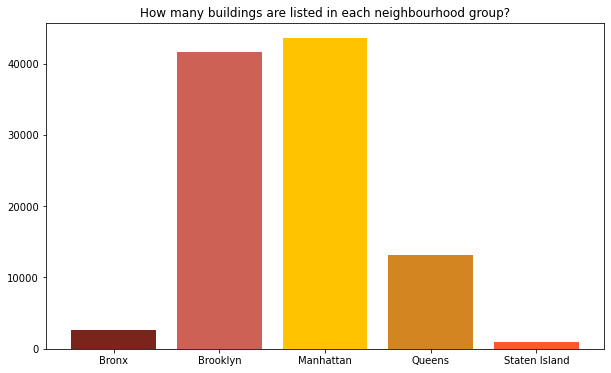

In [31]:
# Grouping by Date and getting the count of IDs
colors = ['#7B241C', '#CD6155', '#FFC300', '#D38521', '#FF5733']
date_counts = df.groupby('neighbourhood group')['id'].count().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(date_counts['neighbourhood group'], date_counts['id'], color=colors)

plt.title('How many buildings are listed in each neighbourhood group?')

plt.show()

#### Question 2. How many reviews are there throughout years?
Reviews were on a hype train until 2019 when reality hit hard in 2020, thanks to COVID. The review count took a nosedive, capturing the wild ride of a pandemic year.

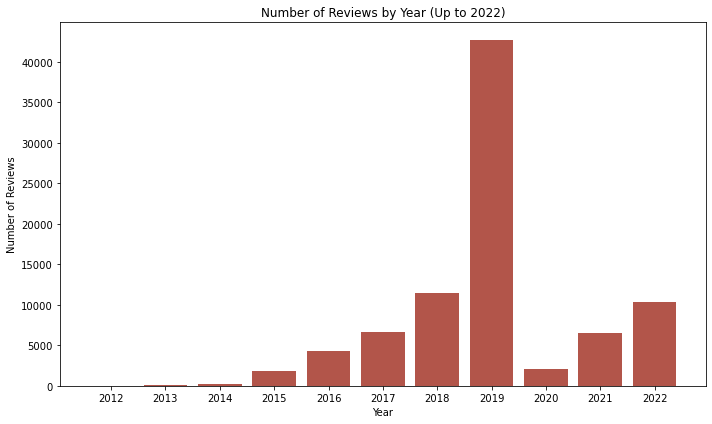

In [32]:
df['last_review'] = pd.to_datetime(df['last review'])
df['year'] = df['last_review'].dt.year

# Filter the DataFrame for observations before or equal to 2022
df_filtered = df[df['year'] <= 2022]

# Count the reviews for each year
yearly_review_counts = df_filtered['year'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(yearly_review_counts.index, yearly_review_counts.values, color='#B2554A')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Year (Up to 2022)')
plt.xticks(yearly_review_counts.index)
plt.tight_layout()
plt.show()

#### Question 3. How is the review score changing over time for different neighbourhood groups? 

As the platform accumulates an increasing number of reviews, an intriguing trend emerges in the evolution of scores across various neighborhood groups. The dynamic landscape of reviews is fostering a gradual convergence of scores, harmonizing the evaluative spectrum between 3.0 and 3.5. This phenomenon suggests a leveling effect, indicating a nuanced equilibrium as neighborhoods receive more comprehensive feedback. 

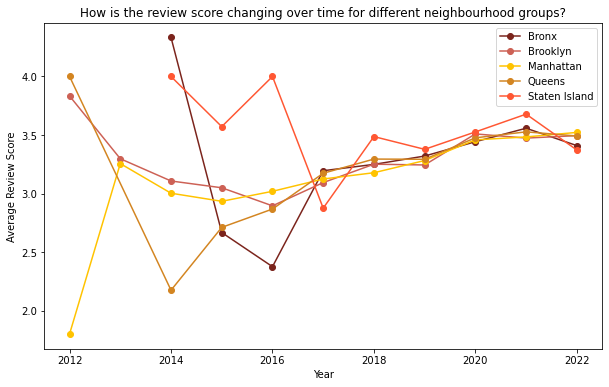

In [33]:
grouped = df[df['last review category'] != 'no date']
grouped['year'] = grouped['last review'].dt.year
grouped = grouped.groupby(['neighbourhood group', 'year'])['review rate number'].mean().reset_index()

# Select neighborhoods and their corresponding colors (adjust as needed)
neighborhoods_to_plot = {
    'Bronx': '#7B241C',
    'Brooklyn': '#CD6155',
    'Manhattan': '#FFC300',
    'Queens': '#D38521',
    'Staten Island': '#FF5733'
}

# Create a single line graph for all selected neighborhoods
plt.figure(figsize=(10, 6))

for neighborhood, color in neighborhoods_to_plot.items():
    neighborhood_data = grouped[grouped['neighbourhood group'] == neighborhood]
    plt.plot(neighborhood_data['year'], neighborhood_data['review rate number'], marker='o', label=neighborhood, color=color)

plt.title('How is the review score changing over time for different neighbourhood groups?')
plt.xlabel('Year')
plt.ylabel('Average Review Score')
plt.legend()
plt.show()

# 4. Which words are most common in the name of the building? How are they different for properties with low and high review score?

Q1 (25th percentile): 2.0
Median (50th percentile): 3.0
Q3 (75th percentile): 4.0


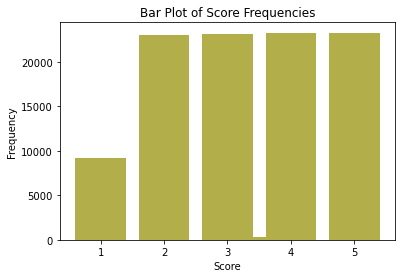

In [34]:

# count quartiles for the review score. high score - above 3rd quartile, low - less then 1st quartile

data = df['review rate number']

# Calculate quartiles
q1 = np.percentile(data, 25)
median = np.percentile(data, 50)
q3 = np.percentile(data, 75)

print("Q1 (25th percentile):", q1)
print("Median (50th percentile):", median)
print("Q3 (75th percentile):", q3)

# Count the occurrences of each unique score
score_counts = df['review rate number'].value_counts().sort_index()

# Extract unique scores and their counts
unique_scores = score_counts.index
score_frequencies = score_counts.values

# Create a bar plot
plt.bar(unique_scores, score_frequencies,  color='#B2AF4A')

# Add labels and title
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Bar Plot of Score Frequencies')

# Show the plot
plt.show()

In [35]:
import pandas as pd
import string
import re
import nltk


# Assuming df is your DataFrame

# Preprocess the 'name' column
df['name_clean'] = df['NAME'].astype(str).str.lower()  # Convert to lowercase
df['name_clean'] = df['name_clean'].str.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

# Remove numbers
df['name_clean'] = df['name_clean'].apply(lambda x: re.sub(r'\d+', '', x))

# Tokenize the 'name' column
# nltk.download('punkt')  # Uncomment if not already downloaded
df['name_tokens'] = df['name_clean'].apply(word_tokenize)

# Filter out common prepositions and stopwords
nltk.download('stopwords')  # Download stopwords if not already downloaded
stop_words = set(stopwords.words('english'))
df['name_tokens'] = df['name_tokens'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marinaromanova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


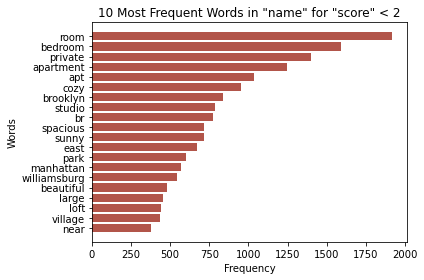

In [37]:
# for lower score
filtered_df = df[df['review rate number'] < 2]

# Flatten the tokenized 'name' column and calculate word frequencies
all_tokens = [token for sublist in filtered_df['name_tokens'] for token in sublist]
freq_dist = FreqDist(all_tokens)

# Get the 10 most frequent words and reverse the order
top_words = freq_dist.most_common(20)[::-1]

# Display the results in a horizontal bar graph
word, frequency = zip(*top_words)
plt.barh(word, frequency, color='#B2554A')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('10 Most Frequent Words in "name" for "score" < 2')
plt.tight_layout()
plt.show()

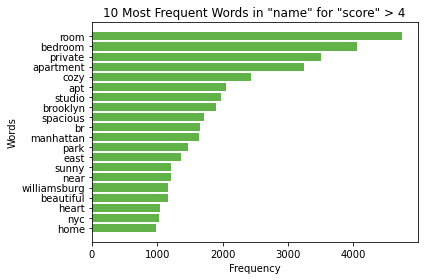

In [38]:
# for higher score
filtered_df = df[df['review rate number'] > 4]

# Flatten the tokenized 'name' column and calculate word frequencies
all_tokens = [token for sublist in filtered_df['name_tokens'] for token in sublist]
freq_dist = FreqDist(all_tokens)

# Get the 10 most frequent words and reverse the order
top_words = freq_dist.most_common(20)[::-1]

# Display the results in a horizontal bar graph
word, frequency = zip(*top_words)
plt.barh(word, frequency, color='#62B24A')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('10 Most Frequent Words in "name" for "score" > 4')
plt.tight_layout()
plt.show()

In [ ]:
# 5. Calculate sentiment score based on the name and rules. Diaplay sentimant score of each neighbourhood

In [ ]:
# text preprocessing of 'rules' column
df['house_rules_clean'] = df['house_rules'].str.lower()  # Convert to lowercase
df['house_rules_clean'] = df['house_rules_clean'].str.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
df['house_rules_clean'] = df['house_rules_clean'].apply(lambda x: re.sub(r'\d+', '', x))

# Define a function to calculate sentiment scores using TextBlob
def calculate_sentiment(text):
    if pd.notna(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return None

# Apply the sentiment analysis function to the 'name' and 'rules' columns and store the results in new columns
df['name_sentiment'] = df['name_clean'].apply(calculate_sentiment)
df['rules_sentiment'] = df['house_rules_clean'].apply(calculate_sentiment)

# Calculate the combined sentiment score as the average of 'name_sentiment' and 'rules_sentiment'
df['combined_sentiment'] = df.apply(lambda row: row['name_sentiment'] if pd.notna(row['name_sentiment']) else row['rules_sentiment'], axis=1)
df.head()

In [ ]:
# Group by Neighbourhood and Calculate Average Score
avg_scores = df.groupby('neighbourhood')['combined_sentiment'].mean().reset_index()



In [ ]:
import matplotlib.pyplot as plt

# Assuming avg_scores is already calculated as df.groupby('neighbourhood')['combined_sentiment'].mean().reset_index()

# Plotting the average sentiment scores
plt.figure(figsize=(12, 6))
plt.bar(avg_scores['neighbourhood'], avg_scores['combined_sentiment'], color='skyblue')
plt.xlabel('Neighbourhood')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Scores by Neighbourhood')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
df.head(1)